In [1]:
!pip install torchaudio boto3

#from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision import transforms, utils
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import PIL
from scipy import signal

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
for i in [os.path.join("/content/gdrive/MyDrive/challenge_dataset",k) for k in os.listdir("/content/gdrive/MyDrive/challenge_dataset")]:
  for z in os.listdir(i):
    metadata = torchaudio.info(os.path.join(i,z))
    if metadata.num_channels != 1:
      print("channels : ", metadata.num_channels)
    if metadata.sample_rate != 44100:
      print("sample_rate : ",metadata.sample_rate)
    if metadata.num_frames != 63000:
      print("num_frames", metadata.num_frames)
    if metadata.bits_per_sample != 16:
      print("bits_per_sample : ",metadata.bits_per_sample)
# confirms that all the audio files have single channel and same sample_rate and same bits_per_sample, but have varying num_frames, so we have to make
# all audio files of same length

num_frames 74970
num_frames 404407
num_frames 338688
num_frames 97020
num_frames 66150
num_frames 316982
num_frames 450350
num_frames 61740
num_frames 333376
num_frames 88200
num_frames 338688
num_frames 455328
num_frames 65895
num_frames 88200
num_frames 140894
num_frames 288876
num_frames 346757
num_frames 380503
num_frames 243767
num_frames 83901
num_frames 72355
num_frames 49153
num_frames 394829
num_frames 943212
num_frames 396288
num_frames 392876
num_frames 112716
num_frames 264600
num_frames 96436
num_frames 182400
num_frames 838383
num_frames 64751
num_frames 349235
num_frames 329348
num_frames 604800
num_frames 264600
num_frames 441000
num_frames 19304
num_frames 441000
num_frames 441000
num_frames 169600
num_frames 365148
num_frames 846251
num_frames 705600
num_frames 441000
num_frames 122040
num_frames 88200
num_frames 110250
num_frames 30000
num_frames 352800
num_frames 441000
num_frames 149404
num_frames 84672
num_frames 919261
num_frames 215002
num_frames 81029
num_frame

In [4]:
num_frames = []
for i in [os.path.join("/content/gdrive/MyDrive/challenge_dataset",k) for k in os.listdir("/content/gdrive/MyDrive/challenge_dataset")]:
  for z in os.listdir(i):
    metadata = torchaudio.info(os.path.join(i,z))
    num_frames.append(metadata.num_frames)

In [5]:
print(min(num_frames))

14080


In [6]:
def resize(waveform,sample_rate,max_time):
  max_length = sample_rate//1000*max_time
  rows_len,waveform_len = waveform.shape
  if(waveform_len<max_length):
    begin_len = (max_length-waveform_len)//2
    end_len = max_length-waveform_len-begin_len
    begin_pad = torch.zeros((rows_len, begin_len))
    end_pad = torch.zeros((rows_len, end_len))
    waveform = torch.cat((begin_pad, waveform, end_pad), 1)
  else:
    waveform = waveform[:,:max_length]
  return waveform

In [7]:
print(metadata)
waveform, sample_rate= torchaudio.load(os.path.join(i,z))
print(waveform.shape)
print(z)

AudioMetaData(sample_rate=44100, num_frames=63000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
torch.Size([1, 63000])
123805.wav


In [8]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spect = T.MelSpectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels = 128
)
todb = T.AmplitudeToDB(top_db = 70)

In [130]:
class My_Dataset(Dataset):
  def __init__(self,path):
    self.classes = os.listdir(path)
    self.len = 0
    self.audios_path = []
    #self.audios_id = []
    for i in self.classes:
      new_path = os.path.join(path,i)
      for j in os.listdir(new_path):
        self.audios_path.append([os.path.join(new_path,j),(i)])
      #self.audios_dirs = os.listdir(new_path)
      #self.audios_path.append(self.audios_dirs)
      #self.len += len(self.audios_dirs)
  def __len__(self):
    return len(self.audios_path)
  def __getitem__(self,idx):
    waveform, sample_rate = torchaudio.load(self.audios_path[idx][0])
    waveform = resize(waveform,sample_rate,4000)
    waveform = spect(waveform)
    waveform = todb(waveform)
    waveform = torch.squeeze(waveform)
    waveform = waveform.numpy()
    new_waveform = []
    for i in range(128):
      #print(waveform)
      #print(signal.resample(waveform[i],num = 128))
      new_waveform.append(signal.resample(waveform[i],num = 128))
    #print(new_waveform)
    new_waveform = np.array(new_waveform)
    new_waveform = torch.from_numpy(new_waveform)
    label = np.zeros(7)
    label[int(self.audios_path[idx][1])-1] = 1
    self.audios_path[idx][1]
    
    #new_waveform =  transforms.Normalize((0.5,0.5), (0.5,0.5))(new_waveform)
    new_waveform = torch.unsqueeze(new_waveform,0)
    return new_waveform,label

In [131]:
audio_dataset = My_Dataset("/content/gdrive/MyDrive/challenge_dataset")
audio_dataset[0][0].shape

torch.Size([1, 128, 128])

In [132]:
audio_dataset = My_Dataset("/content/gdrive/MyDrive/challenge_dataset")
train_len = int(0.7*len(audio_dataset))
val_len = int(0.15*len(audio_dataset))
test_len = len(audio_dataset) - train_len - val_len
train_data, val_data, test_data = random_split(audio_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))
train_dl = DataLoader(train_data,batch_size=10,shuffle = True)
val_dl = DataLoader(val_data,batch_size=10,shuffle = True)
test_dl = DataLoader(test_data,batch_size=10,shuffle = True)

In [158]:
batch_size = 10

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 8)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(4, 10, 10)
        self.fc1 = nn.Linear(250, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()

criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)




In [162]:
loss_arr = []
for epoch in range(100):  # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(train_dl, 0):
    #print(i)
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print(inputs.shape)
    # zero the parameter gradients
    optimizer.zero_grad()
    #print(labels)
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criteria(outputs, labels)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()
    if i % 5 == 4:    # print every 20 mini-batches
      print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss / 5))
      loss_arr.append(running_loss/5)
      running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.174
[2,     5] loss: 0.179
[3,     5] loss: 0.115
[4,     5] loss: 0.141
[5,     5] loss: 0.241
[6,     5] loss: 0.134
[7,     5] loss: 0.175
[8,     5] loss: 0.112
[9,     5] loss: 0.112
[10,     5] loss: 0.104
[11,     5] loss: 0.074
[12,     5] loss: 0.635
[13,     5] loss: 0.111
[14,     5] loss: 0.081
[15,     5] loss: 0.091
[16,     5] loss: 0.081
[17,     5] loss: 0.070
[18,     5] loss: 0.072
[19,     5] loss: 0.072
[20,     5] loss: 0.064
[21,     5] loss: 0.059
[22,     5] loss: 0.073
[23,     5] loss: 0.068
[24,     5] loss: 0.053
[25,     5] loss: 0.052
[26,     5] loss: 0.055
[27,     5] loss: 0.064
[28,     5] loss: 0.058
[29,     5] loss: 0.043
[30,     5] loss: 0.055
[31,     5] loss: 0.041
[32,     5] loss: 0.055
[33,     5] loss: 0.035
[34,     5] loss: 0.040
[35,     5] loss: 0.041
[36,     5] loss: 0.038
[37,     5] loss: 0.040
[38,     5] loss: 0.040
[39,     5] loss: 0.034
[40,     5] loss: 0.035
[41,     5] loss: 0.031
[42,     5] loss: 0.037
[

In [163]:
print(loss_arr)

[0.17438063445559235, 0.17876530059147627, 0.11507727319840341, 0.14064096918096763, 0.2414692025352269, 0.13370346286334098, 0.17455451044254006, 0.11153685800149105, 0.11228327771474142, 0.10393871191336075, 0.07383908905205316, 0.6352690067023286, 0.1108732348086778, 0.08115484830865172, 0.09111390926409513, 0.08100429426413029, 0.06991106751956977, 0.07182458308991044, 0.07170376561349258, 0.06449228387151379, 0.059456490618322276, 0.07251736581150908, 0.06809269828168908, 0.053490559649653734, 0.051765974172303685, 0.0554561236849986, 0.06370151568044094, 0.057984990263285, 0.0431523124720843, 0.05477801401764737, 0.040842984613846056, 0.054627860416803745, 0.03543536031153054, 0.0399028014515352, 0.04087882572537638, 0.037514529623877024, 0.04017017608421157, 0.04040815374581143, 0.034200423030415546, 0.03516546867322177, 0.031096829524904022, 0.03680744750658051, 0.028668818011683472, 0.021332581730348465, 0.03426204932155088, 0.02894083760376816, 0.02406147430869169, 0.02431179

In [168]:
#validation loss
total_loss = 0
for i, data in enumerate(val_dl, 0):

  inputs, labels = data
  #optimizer.zero_grad()

  # forward + backward + optimize
  outputs = model(inputs)
  loss = criteria(outputs, labels)
  #loss.backward()
  #optimizer.step()
  # print statistics
  total_loss += loss.item()


print(total_loss/val_len)

0.506939574012713


Text(0, 0.5, 'Losses')

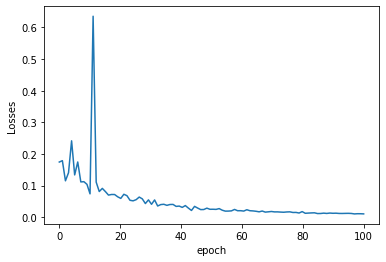

In [169]:
plt.plot(np.linspace(0,100,100),loss_arr)
plt.xlabel("epoch")
plt.ylabel("Losses")

